In [27]:
import numpy as np
import pandas as pd
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from PIL import Image

In [24]:
def plot_batch(batch, batch_size):
    assert batch_size % 4 == 0
    side = batch_size // 4
    fig = plt.figure(figsize=(8, 8))
    for idx in np.arange(batch_size):
        ax = fig.add_subplot(side, side, idx+1, xticks=[], yticks=[])
        imshow(batch[idx])
        
def plot_batch_numpy(batch, batch_size):
    assert batch_size % 4 == 0
    side = batch_size // 4
    fig = plt.figure(figsize=(8, 8))
    for idx in np.arange(batch_size):
        ax = fig.add_subplot(side, side, idx+1, xticks=[], yticks=[])
        plt.imshow(batch[idx])
        
def plot_images(imgs, names=None):        
    fig, axs = plt.subplots(ncols=len(imgs), figsize=(16, 8))
    for i, ax in enumerate(axs):
        ax.imshow(imgs[i])
        if names and i < len(names):
            ax.set_title(names[i], fontsize=15)
    plt.show()
    
def plot_image(img, img_size=5):
    img = np.array(img)

    height, width = img.shape[:2]
    fig = plt.figure()
    fig.set_size_inches(width / height * img_size, img_size, forward=True)
    ax = plt.Axes(fig, [0., 0., 1, 1])
    fig.add_axes(ax)
    ax.imshow(img)

    plt.show()

In [20]:
def get_preprocessed_image(path: str) -> Tensor:
    image = read_image(path)
    image_tensor = preprocess_image(image)

    return image_tensor

def read_image(path: str) -> np.ndarray:
    image = cv2.imread(path)[..., ::-1]

    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    return image

def preprocess_image(image: np.ndarray) -> Tensor:
    
    transform = transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    
    image_tensor = transform(Image.fromarray(image))

    return image_tensor

In [3]:
class Embedder(nn.Module):
    def __init__(self):
        super(Embedder, self).__init__()
        self.embedder = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 4, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
    def forward(self, x):
        embed = self.embedder(x)
        
        bs = embed.size()[0]
        
        return embed.view(bs, -1)

In [4]:
class Index:
    def __init__(self, embeddings):
        self.embeddings = embeddings
    
    def rank(self, embedding, top_k=16):
        dists = self.calc_dists(embedding)
        order = np.argsort(dists)
        
        return order[:top_k], dists[order][:top_k]
    
    def calc_dists(self, embedding):
        dists = self.embeddings - embedding
        dists = np.linalg.norm(dists, axis=1)
        
        return dists

In [7]:
path_to_the_model = "embedder.pth"

In [8]:
embedder = Embedder()
embedder.load_state_dict(torch.load(path_to_the_model))
embedder.eval()

Embedder(
  (embedder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
)

In [33]:
def rank_and_plot(path):
    img = read_image(path)
    plot_image(img, 2)
    
    tensor = preprocess_image(img).unsqueeze(0)
    
    out = embedder(tensor).detach().numpy()
    
    ids, dists = index.rank(out)
    
    top_paths = [data.path[iid] for iid in ids]
    
    top_imgs = [cv2.imread(path)[..., ::-1] for path in top_paths]
    
    plot_batch_numpy(top_imgs, 16)

In [10]:
path_to_the_embeddings = "embeddings.npy"

In [11]:
embeddings = np.load(path_to_the_embeddings)

In [12]:
index = Index(embeddings)

In [14]:
test_data = pd.read_csv("test.csv")

In [25]:
data = pd.read_csv('train.csv')

In [17]:
test_batch = test_data.sample(10)

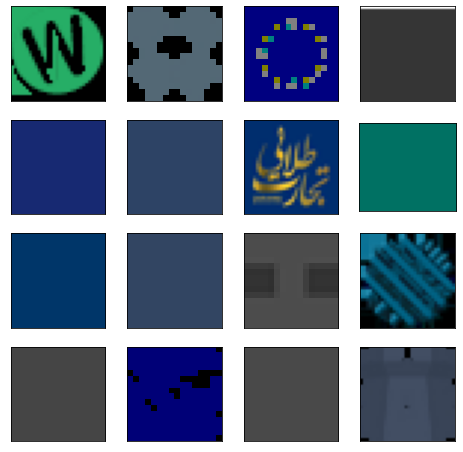

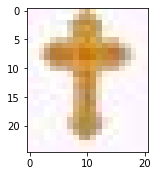

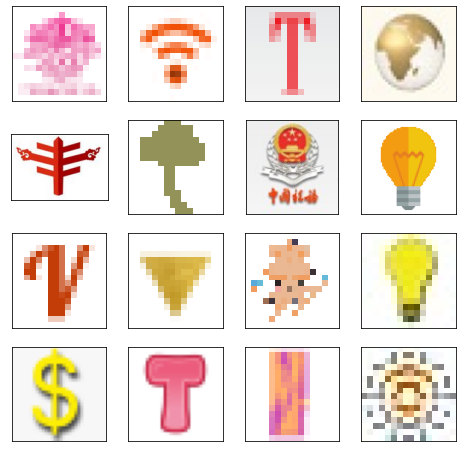

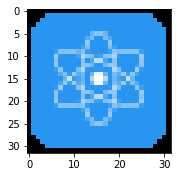

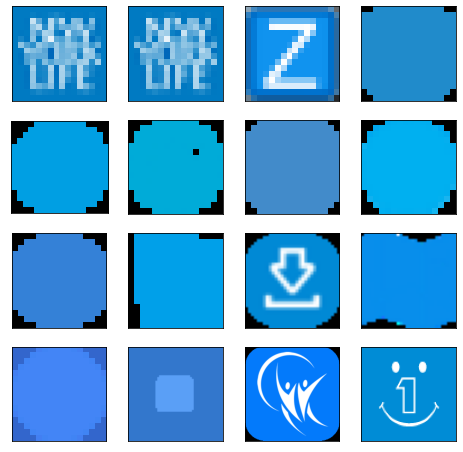

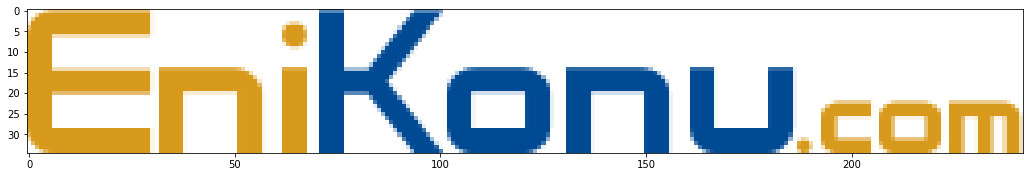

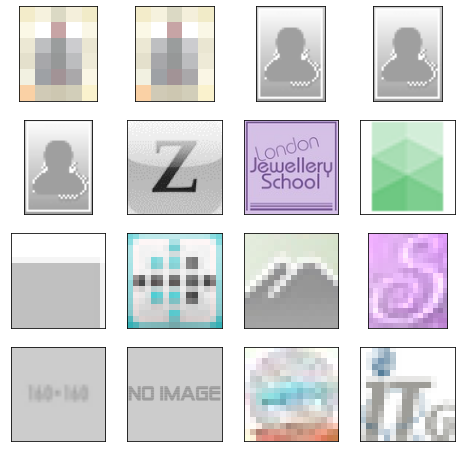

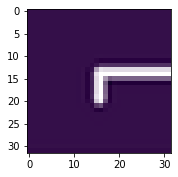

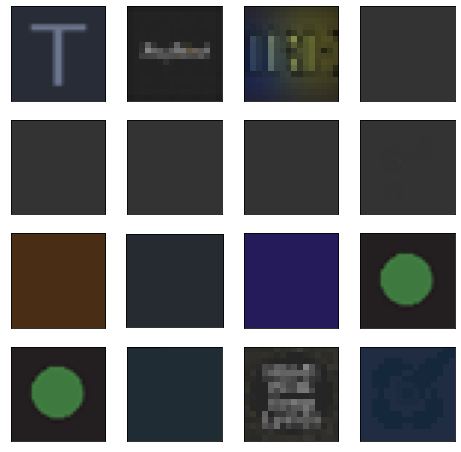

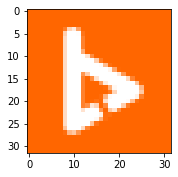

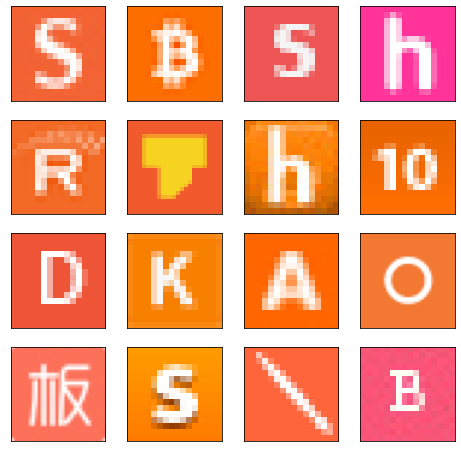

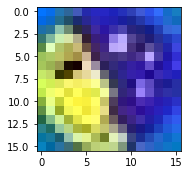

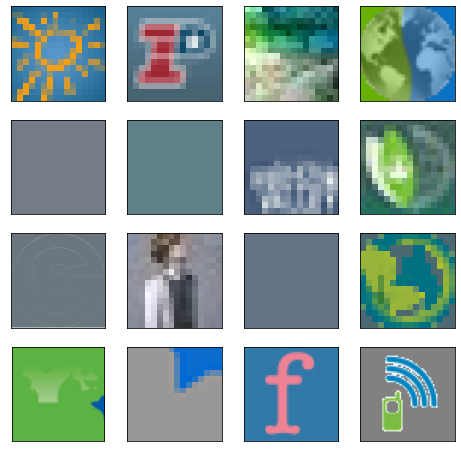

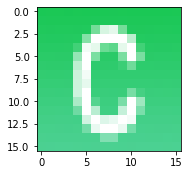

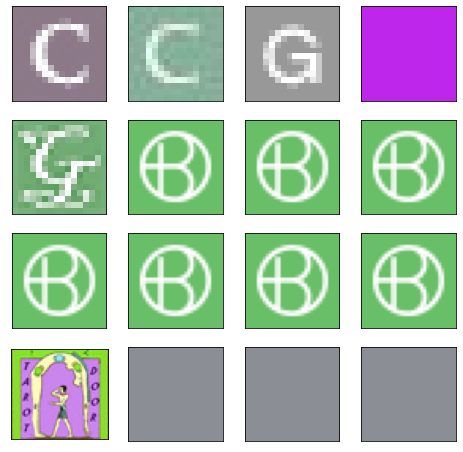

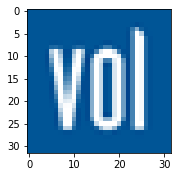

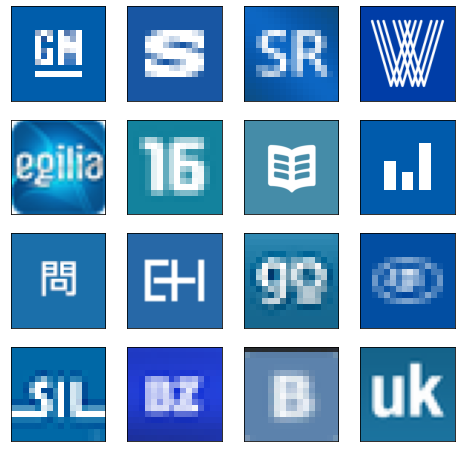

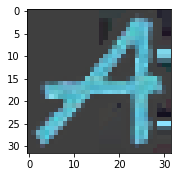

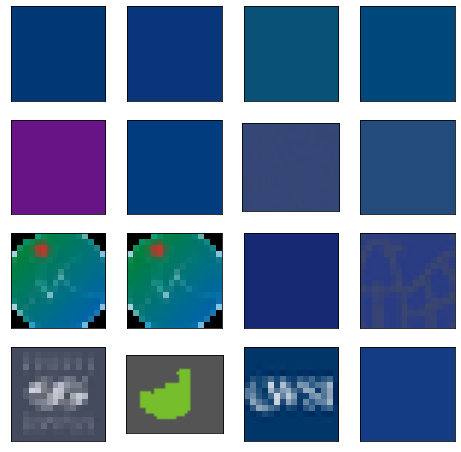

In [34]:
for path in test_batch.path:
    rank_and_plot(path)